<a href="https://colab.research.google.com/github/Casatimartina/Algorithm-for-Massive-dataset/blob/main/Market-basket%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market basket analysis: IMDb Dataset

#### Casati Martina (942413)
#### Frattini Andrea (959213) 
#####DSE(2020-2021)

## Download the dataset through Kaggle API

First, upload the kaggle file in which is stored the username and the key for dowloading the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Saving kaggle.json to kaggle.json


Then we check which is our dataset of interest

In [ ]:
!kaggle datasets list -s 'IMDb Dataset'

ref                                                             title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
ashirwadsangwan/imdb-dataset                                    IMDb Dataset                                        1GB  2019-11-18 18:36:47           7662  
stefanoleone992/imdb-extensive-dataset                          IMDb movies extensive dataset                      82MB  2020-09-14 19:02:52          25602  
harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows  IMDB Movies Dataset                               175KB  2021-02-01 07:35:48           4413  
lakshmi25npathi/imdb-dataset-of-50k-movie-reviews               IMDB Dataset of 50K Movie Reviews                  26MB  2019-03-09 06:32:21          46235  
utathya/imdb-review-dataset                         

From the list above we see that the first dataset ("IMDb Dataset") is the right one, so we dowload it

In [ ]:
!kaggle datasets download -d 'ashirwadsangwan/imdb-dataset'

100% 1.44G/1.44G [00:15<00:00, 112MB/s]
100% 1.44G/1.44G [00:15<00:00, 103MB/s]


Through the string below we extrapolate the files

In [ ]:
!unzip \*.zip && rm *.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## Setting up the COLAB environment

With the first part of this code we set up the Spark environment and secondly we import all the packages necessary for managing and analyzing the dataset

In [ ]:
!pip3 install pyspark
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import collect_set, col, count

import itertools

import pandas as pd

import time

import matplotlib.pyplot as plt

     |████████████████████████████████| 212.4MB 67kB/s 
     |████████████████████████████████| 204kB 15.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=9e5e4ede30e4a5224cf982a54e42370b7e8d85aac27720ae517e77176869d1e4
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


Here we set the SparkConf

In [ ]:
conf = SparkConf().setAppName("MarketBasketAnalysis")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '16G')
        .set('spark.driver.memory', '60G')
        .set('spark.driver.maxResultSize', '12G'))
sc = SparkContext( conf= conf)

## Setting up the Jupyter Notebook environment for the VM of Google Cloud Platform

ATTENTION: from here on, if you want to run the codes using a VM you need to substitute sqlContext command with spark

In [ ]:
!pip install pyspark
import pyspark
from pyspark import SparkContext
sc = pyspark.SparkContext('local[*]')
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col, count
spark = SparkSession.builder.appName("Market Basekt Analysis").getOrCreate()

import itertools

import pandas as pd

import time

import matplotlib.pyplot as plt

## Loading the datasets

First we import the tables of interest assigning to them intuitive labels. Secondly we show the first 10 rows of each one to understand how they are structured.

In [ ]:
sqlContext = SQLContext(sc)
FilmTitle = sqlContext.read.csv("/content/title.basics.tsv", sep=r'\t', header=True)
Job = sqlContext.read.csv("/content/title.principals.tsv", sep=r'\t', header=True)
NamesCast = sqlContext.read.csv("/content/name.basics.tsv", sep=r'\t', header=True)

In [ ]:
FilmTitle.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [ ]:
Job.show(10)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

In [ ]:
NamesCast.show(10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

## PreProcessing

First we set the Spark SQL environment 

In [ ]:
FilmTitle.createOrReplaceTempView("FilmTitle")
Job.createOrReplaceTempView("Job")

Secondly, since we need to consider actors and actresses as items, we extrapolate them from the "Job" table

In [ ]:
actors =  """ SELECT *
              FROM Job
              WHERE (category = 'actor') OR (category = 'actress')
"""
actors = sqlContext.sql(actors)
actors.show(10)

+---------+--------+---------+--------+---+--------------------+
|   tconst|ordering|   nconst|category|job|          characters|
+---------+--------+---------+--------+---+--------------------+
|tt0000005|       1|nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2|nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1|nm0179163|   actor| \N|                  \N|
|tt0000007|       2|nm0183947|   actor| \N|                  \N|
|tt0000008|       1|nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1|nm0063086| actress| \N|["Miss Geraldine ...|
|tt0000009|       2|nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3|nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1|nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1|nm0166380|   actor| \N|    ["The Gardener"]|
+---------+--------+---------+--------+---+--------------------+
only showing top 10 rows



And then we extrapolate the movies from the table FilmTitle, since we need to use them as baskets

In [ ]:
movies =  """ SELECT *
              FROM FilmTitle
              WHERE titleType = 'movie'
         """
movies = sqlContext.sql(movies)
movies.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

Finally, we create the baskets joining the "Job" and "FilmTitle" tables considering only the actors, actresses and movies. Then we group by the ID of actors and actresses (tconst) and we list the title of the films in which they played under the 'ncosnt' column.

In [ ]:
B =  """  SELECT Job.tconst, Job.nconst
          FROM Job LEFT JOIN FilmTitle ON Job.tconst = FilmTitle.tconst
          WHERE (Job.category == 'actor' OR Job.category == 'actress') AND FilmTitle.titleType == 'movie'
"""
a = sqlContext.sql(B)
baskets = a.groupBy('tconst').agg(collect_set('nconst').alias('nconst'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5)

+---------+--------------------+
|   tconst|              nconst|
+---------+--------------------+
|tt0002591|[nm0029806, nm050...|
|tt0003689|[nm0910564, nm052...|
|tt0004272|[nm0368875, nm009...|
|tt0004336|[nm0268437, nm081...|
|tt0005209|[nm0593671, nm039...|
+---------+--------------------+
only showing top 5 rows



Here we create a Resilient Distributed Dataset

In [ ]:
act_bask = baskets.select('nconst').rdd.flatMap(list)
print(act_bask.collect()[:3])

[['nm0029806', 'nm0509573'], ['nm0910564', 'nm0527801', 'nm0399988', 'nm0101071', 'nm0694718', 'nm0728289', 'nm0585503'], ['nm0368875', 'nm0092665', 'nm0492302', 'nm0445507', 'nm0776747', 'nm0383278', 'nm0192062', 'nm0285643', 'nm0793189']]


## The A-Priori Algorithm

We initialize a threshold value after which the pairs of actors and actresses are considered frequent using a fraction (0.03%) of the number of baskets 

In [ ]:
count = act_bask.count()
threshold = count*0.0003
print(count, threshold)


393656 118.09679999999999


Exploiting the functions "map", "reduceByKey" and "filter" of Spark (https://spark.apache.org/docs/latest/rdd-programming-guide.html) we create the A-Priori algorithm: this function takes as input an RDD and a threshold (previously defined); in the following we describe in details the code:
- singleton: through .flatMap we create a list, subsequently .map maps the item creating a tuple with the ID of the actor/actress and a counter (number of film in which he/her partecipated), then .reduceByKey, using actor/actress as key, sum their values up and finally .filter check if the counter of the previuos tuple is greater or equal than the threshold.
- freq_act: with .map we extrapolate from 'singleton' only the ID of the frequent actors/actresses
- pairs_of_freq_act = using .toLocalIterator we find all the possible pairs within the frequent_act
- table_of_pairs: through .flatMap we create a list and we add to it each item in pairs_of_freq_act that is a subset of a basket, then with .reduceByKey we sum up the actors/actresses using them as keys and finally with .filter we filter out all the items that have the second component (item[1], i.e. the counter) greater than the threshold.

In [ ]:
def apriori (rdd, threshold):
  
  singleton = rdd.flatMap(list).map(lambda item: (item , 1)).reduceByKey(lambda actor1, actor2: actor1+actor2).filter(lambda item: item[1] >= threshold ) 

  freq_act = singleton.map(lambda item : (item[0])) # all the pair of frequent items 

  pairs_of_freq_act = list(itertools.combinations(freq_act.toLocalIterator(),2)) # finding all the possible pairs
  
  table_of_pairs = rdd.flatMap(lambda x : [(tuple(item), 1) for item in pairs_of_freq_act if set(list(item)).issubset(set(x))]).cache() \
                  .reduceByKey(lambda actor1, actor2: actor1+actor2) \
                  .filter(lambda item: item[1] >= threshold)

  return (table_of_pairs)

We run the A-Priori algorithm on on the enitre dataset and then we put the results into a dataframe in order to show tham in a pretty way 

In [ ]:
AprioriResults = apriori(act_bask, threshold)
result = sqlContext.createDataFrame(AprioriResults).toDF("Pairs of actors and actresses", "Number of movies")
result.show()

+-----------------------------+----------------+
|Pairs of actors and actresses|Number of movies|
+-----------------------------+----------------+
|         {nm0623427, nm000...|             237|
|         {nm0006982, nm061...|             122|
|         {nm0006982, nm041...|             162|
|         {nm0046850, nm000...|             169|
|         {nm2082516, nm064...|             147|
|         {nm2373718, nm064...|             126|
+-----------------------------+----------------+



Now we calculate the time necessary for running the algorithm on the entire dataset

In [ ]:
startTime = time.time()
apriori(act_bask, threshold)
APrioriTime = time.time()-startTime
print(time.time()-startTime)

34.578014850616455


## FP Growth Algorithm

Using the library of FPGrowth we launch it and we calculate the running time

In [ ]:
from pyspark.ml.fpm import FPGrowth
startTime = time.time()
fp = FPGrowth(itemsCol = "nconst", minSupport = 0.0003)
startTime = time.time()
FPGrowth_model = fp.fit(baskets)
FPGrowthTime = time.time()- startTime
print(time.time()- startTime)

15.930326461791992


We display the 10 most frequent items

In [ ]:
FPGrowth_model.freqItemsets.show(10)

+-----------+----+
|      items|freq|
+-----------+----+
|[nm1388202]| 153|
|[nm0430646]| 120|
|[nm0103977]| 798|
|[nm0006982]| 585|
|[nm0436922]| 152|
|[nm0408381]| 120|
|[nm0648803]| 565|
|[nm0405977]| 152|
|[nm0576495]| 120|
|[nm0579663]| 120|
+-----------+----+
only showing top 10 rows



In [ ]:
FPGrowth_model= FPGrowth_model.freqItemsets
FPGrowth_model.createOrReplaceTempView("FPGrowth_model")

In [ ]:
q = """ SELECT *
        FROM FPGrowth_model 
        WHERE size (items) >= 2
        ORDER BY freq DESC
        """
sqlContext.sql(q).show(10)

+--------------------+----+
|               items|freq|
+--------------------+----+
|[nm0623427, nm000...| 237|
|[nm0046850, nm000...| 169|
|[nm0419653, nm000...| 162|
|[nm2082516, nm064...| 147|
|[nm2373718, nm064...| 126|
|[nm0619779, nm000...| 122|
+--------------------+----+



## Running time comparisons between A-Priori and FP Growth algorithms 

A-Priori vs FP Growth given the entire dataset and the same threshold (0.0003)

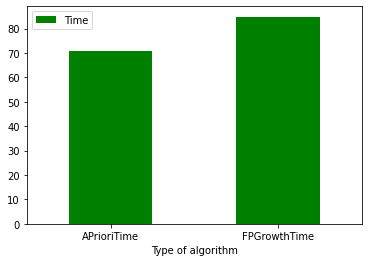

In [ ]:
df = pd.DataFrame({'Type of algorithm':['APrioriTime', 'FPGrowthTime'], 'Time':[APrioriTime,FPGrowthTime]})
barplot = df.plot.bar(x='Type of algorithm', y='Time', rot = 0, color= 'g')

A-Priori vs FP Growth given the entire dataset but different threshold values, run on COLAB

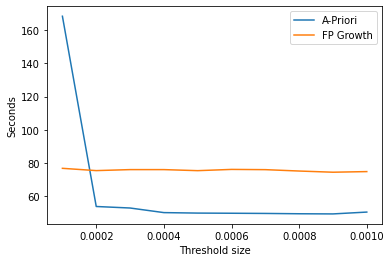

In [ ]:
%matplotlib inline
x = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
y = [168.30824089050293,53.98464870452881,53.07268238067627,50.30917692184448,50.021188735961914,49.92609214782715,49.81086301803589,49.619282960891724,
     49.52366256713867,50.62602353096008]
plt.plot(x, y, label='A-Priori')

a = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
b = [76.92273926734924,75.54928350448608,76.14759802818298,76.14860796928406,75.51765608787537,76.26800203323364,76.12276768684387,75.29264044761658,
     74.58063530921936,74.95723581314087]
plt.plot(a, b, label='FP Growth')

plt.xlabel("Threshold size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('A-Priori vs FP.pdf')
plt.show()

A-Priori vs FP Growth given the entire dataset but different threshold values, run on the Google Cloud Platform's VM

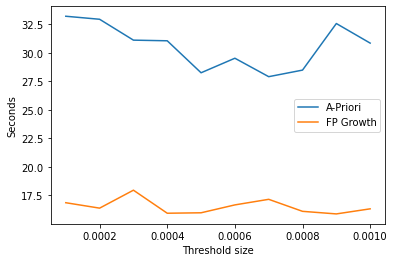

In [ ]:
%matplotlib inline
x = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
y = [33.20604872703552,32.940818309783936,31.111687421798706,31.05544662475586,28.253437519073486,29.52706813812256,
    27.911072731018066,28.486892223358154,32.56802487373352,30.852026224136353]
plt.plot(x, y, label='A-Priori')

a = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
b = [16.866843700408936,16.3917453289032,17.964827060699463,15.945896625518799,15.984309434890747,16.67537784576416,
    17.164546251296997,16.111791610717773,15.885606050491333,16.331362009048462]
plt.plot(a, b, label='FP Growth')

plt.xlabel("Threshold size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('A-Priori vs FP.pdf')
plt.show()

Running time comparison between COLAB and the VM

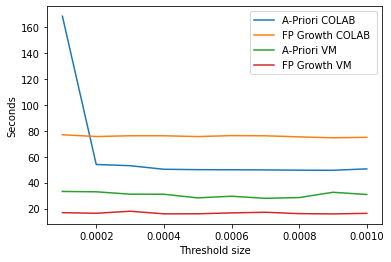

In [ ]:
%matplotlib inline
x = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
y = [168.30824089050293,53.98464870452881,53.07268238067627,50.30917692184448,50.021188735961914,49.92609214782715,49.81086301803589,49.619282960891724,
     49.52366256713867,50.62602353096008]
plt.plot(x, y, label='A-Priori COLAB')

a = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
b = [76.92273926734924,75.54928350448608,76.14759802818298,76.14860796928406,75.51765608787537,76.26800203323364,76.12276768684387,75.29264044761658,
     74.58063530921936,74.95723581314087]
plt.plot(a, b, label='FP Growth COLAB ')

c = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
d = [33.20604872703552,32.940818309783936,31.111687421798706,31.05544662475586,28.253437519073486,29.52706813812256,
    27.911072731018066,28.486892223358154,32.56802487373352,30.852026224136353]
plt.plot(c, d, label='A-Priori VM')

e = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
f = [16.866843700408936,16.3917453289032,17.964827060699463,15.945896625518799,15.984309434890747,16.67537784576416,
    17.164546251296997,16.111791610717773,15.885606050491333,16.331362009048462]
plt.plot(e, f, label='FP Growth VM')

plt.xlabel("Threshold size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('VM vs COLAB.pdf')
plt.show()

A-Priori run through COLAB and the VM of Google Cloud Platform given the same threshold value (0.0003) but different samples of the dataset

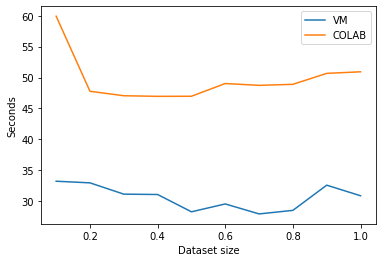

In [ ]:
%matplotlib inline
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
y = [33.20604872703552,32.940818309783936,31.111687421798706,31.05544662475586,28.253437519073486,29.52706813812256,
    27.911072731018066,28.486892223358154,32.56802487373352,30.852026224136353]
plt.plot(x, y, label='VM')

a = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
b = [59.92277193069458,47.767677783966064,47.05071759223938,46.95095682144165,46.964603424072266,49.02852916717529,
     48.7320818901062,48.89626502990723,50.67340040206909,50.92510151863098]
plt.plot(a, b, label='COLAB')

plt.xlabel("Dataset size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('A-Priori.pdf')
plt.show()

FP Growth run through COLAB and the VM of Google Cloud Platform given the same dataset's size but different threshold values

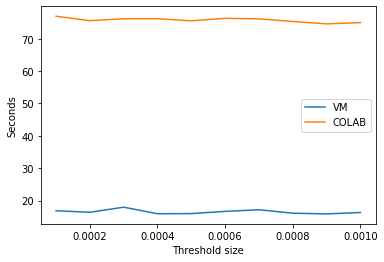

In [ ]:
%matplotlib inline
x = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
y = [16.866843700408936,16.3917453289032,17.964827060699463,15.945896625518799,15.984309434890747,16.67537784576416,
    17.164546251296997,16.111791610717773,15.885606050491333,16.331362009048462]
plt.plot(x, y, label='VM')

a = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
b = [76.92273926734924,75.54928350448608,76.14759802818298,76.14860796928406,75.51765608787537,76.26800203323364,76.12276768684387,75.29264044761658,
     74.58063530921936,74.95723581314087]
plt.plot(a, b, label='COLAB')

plt.xlabel("Threshold size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('FP Growth.pdf')
plt.show()